<a href="https://colab.research.google.com/github/sheilta/TSDN/blob/main/DSI_x_TSDN_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import Package & Data

In [ ]:
# Import package
import pandas as pd # data manipulation and analysis
import numpy as np #fungsi matematika yang komprehensif
import matplotlib.pyplot as plt # membuat plot
import seaborn as sns # opsi lain untuk plot
from scipy import stats 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, silhouette_score
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn import tree
pd.set_option('display.float_format', lambda x: '%.2f' % x) # set 2 angka dibelakang koma (desimal)

Data Source: 
1. covid : kawalcovid19 https://datawrapper.dwcdn.net/MwHOx/581/
2. iris :  UCI Machine Learning https://archive.ics.uci.edu/ml/datasets/iris

In [ ]:
# Import data covid kabupaten kota ('data.csv')
df = pd.read_csv('/content/data.csv')

# Import data iris
df1 = pd.read_csv('/content/iris.csv')

In [ ]:
# menampilkan data teratas untuk data covid
df.head()

In [ ]:
df1.head()

*Note: untuk preprocessing data menggunakan dataset covid karena belum bersih, untuk modeling menggunakan dataset iris karena sudah cleann

# 2. Preprocessing data

In [ ]:
df.info() # Mencari informasi dari dataset, kayak str di R, object=string

## 2.1 Selecting Column

In [ ]:
# slicing dataset (memilih kolom yang diinginkan), X.1 sampe Kabupaten.Kota di keep karena bisa untuk di visualisasi tableau
#Pos T = positif total, pos p= dirawat
df_slice = df[['X.1','Provinsi', 'Kabupaten/Kota','POS T','POS P',
       'POS S', 'POS MD', 'Luas Wilayah',
       'Jumlah Penduduk', 'Penduduk/sq.km', 'X.3']]
df_slice.shape

In [ ]:
df_slice.head()

In [ ]:
df_slice.info()

## 2.2 Handling Missing value

1. drop NaN (menghapus missing value karena tidak digunakan) `df.dropna()`

2. Fill NaN (mengisi missing value karena data digunakan) `df.fillna(df.mean())`

3. Fill NaN dengan interpolasi (baik untuk data continuous) ex: Time series data `df.interpolate(method="polynomial", order=2)`



In [ ]:
null_data = df_slice[df_slice.isnull().any(axis=1)]#is.null buat manggil yang kosong
null_data

In [ ]:
df_drop = df_slice.dropna()#karena yang missing bisa dihapus, maka digunakan dropna
df_drop.shape

##  2.3 Filtering Raw

In [ ]:
# Cek tanggal update, pengin liat tanggal update
#df_drop['X.3] mengambil kolom, value_count dengan dihitung, kemudian di sort(sort_values) kemudian di plot kan
#plot tipe barchart dengan ukuran 10,5
# ax.patches buat label
ax=df_drop['X.3'].value_counts().sort_values(ascending=False)[:10].plot(figsize=(10,5),kind='bar', rot=0, width=0.8)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x(), p.get_height()))

In [ ]:
#tampilkan data selain tanggal 09/18/2021
df_drop[df_drop["X.3"]!="9/18/2021"]

In [ ]:
#filter untuk tanggal 09/18/2021
df_filter = df_drop[df_drop["X.3"]=="9/18/2021"]
df_filter.shape

## 2.4 Rename Column

note: memudahkan proses selanjutnya

In [ ]:
df_rename= df_filter.rename({'X.1': 'kode', 'Provinsi' : 'provinsi', 'Kabupaten/Kota' : 'kabkot','POS T' : 'total','POS P' : 'dirawat',
       'POS S': 'sembuh', 'POS MD' : 'meninggal', 'Luas Wilayah' : 'luas_wilayah',
       'Jumlah Penduduk' : 'jml_penduduk', 'Penduduk/sq.km' :'kepadatan', 'X.3':'tanggal'}, axis=1)
df_rename.head()

## 2.5 Statistik Deskriptif

In [ ]:
#sort data berdasarkan nilainya
df_rename.sort_values(by=['total'])

In [ ]:
#lihat statistik deskriptif nya, bisa keliatan outlier bila dibandingin sama rata2
df_stats=df_rename[['total','dirawat','sembuh','meninggal','kepadatan']]
df_stats.describe()

## 2.6 Handling Outlier

In [ ]:
df_stats.plot(kind='box',subplots=True,layout=(1,5),sharex=False, figsize=(15,5))
plt.show()
#fokus bagian total

In [ ]:
#menangani outlier, cuman memasukkan nilai z score < 3
df_zscore=df_stats[(np.abs(stats.zscore(df_stats)) < 3).all(axis=1)]
df_zscore.plot(kind='box',subplots=True,layout=(1,5),sharex=False, figsize=(15,5))
plt.show()

In [ ]:
df_zscore.shape

In [ ]:
#Versi kedua penanganan outlier
#find Q1, Q3, and interquartile range for each column
Q1 = df_stats.quantile(q=.25)
Q3 = df_stats.quantile(q=.75)
IQR = df_stats.apply(stats.iqr) #IQR=Q3-Q1

#keep nilai antara 1.5*IQR dari Q1 dan Q3, yang nilai lebih dari atau kurang dari dibuang
df_iqr = df_stats[~((df_stats < (Q1-1.5*IQR)) | (df_stats > (Q3+1.5*IQR))).any(axis=1)]
df_iqr.plot(kind='box',subplots=True,layout=(1,5),sharex=False, figsize=(15,5))
plt.show()

In [ ]:
df_iqr.shape

## 2.7 Handling Non Normal Distribution

Note: not mandatory / u can ignoring in some cases

In [ ]:
df_stats.plot(kind='density',subplots=True,layout=(1,5),sharex=False, figsize=(15,5))
plt.show()

In [ ]:
total = df_stats['total'].values#pangiil nilai dari kolom total

In [ ]:
#keliatan ga normal karena condong kiri
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(total, bins='auto', density=True)
ax.set_xlabel('positive')
ax.set_ylabel('probability')
ax.set_title('Non-normal Distribution');

In [ ]:
trans, lmbda = stats.boxcox(total)#penanganan dengan box cox

In [ ]:
print('Best lambda parameter = %s' % round(lmbda, 3))

fig, ax = plt.subplots(figsize=(8, 4))
prob = stats.boxcox_normplot(total, -20, 20, plot=ax)
ax.axvline(lmbda, color='r');

In [ ]:
trans.sort()
mean, std = stats.norm.fit(trans, loc=0)
pdf_norm = stats.norm.pdf(trans, mean, std)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(trans, bins='auto', density=True)
ax.plot(trans, pdf_norm, label='Fitted normal distribution')
ax.set_xlabel('positive')
ax.set_ylabel('Transformed Probability')
ax.set_title('Box-Cox Transformed Distribution')
ax.legend();

## 2.8 Korelasi

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(df_stats.corr(), annot=True,cmap="YlGnBu")

In [ ]:
# Model Data Unspervised

# 3. Modeling

## 3.1 Unspervised 

In [ ]:
X = df_stats[['total','kepadatan']]
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(X['total'], X['kepadatan'], c=kmeans.labels_)
ax.set_xlabel('positive')
ax.set_ylabel('kepadatan')
ax.set_title('kluster');

### 3.1.1. kluster terbaik

In [ ]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(10,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
k = range(2,10)
score=[]
for n_cluster in k:
    kmeans = KMeans(n_clusters=n_cluster).fit(X)
    score.append(silhouette_score(X,kmeans.labels_))
plt.figure(figsize=(10,5))
plt.plot(k, score, 'o-')
plt.xlabel("Value for k")
plt.ylabel("Silhouette score")
plt.title('Silhouette Method')
plt.show()

## 3.2 supervised

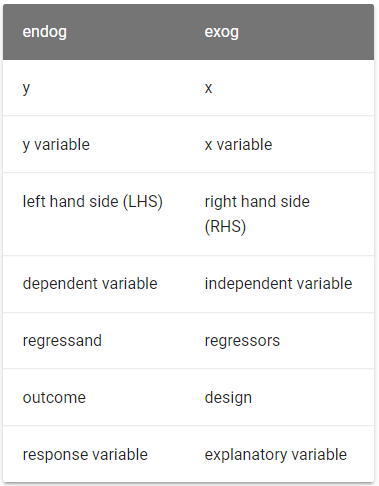

In [ ]:
df1.head()

In [ ]:
sns.pairplot(df1, hue="class",palette='tab10')

In [ ]:
df1['class'].value_counts().plot(figsize=(5,5),kind='pie', autopct = "%.1f%%")

In [ ]:
# memisahkan X dan y
X = df1.drop(['class'], axis=1)
#Encoding class
y=pd.factorize(df1['class'])[0]
y=pd.DataFrame(y,columns=['class'])

In [ ]:
#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3)

### 3.2.1 Decision Tree


In [ ]:
dtree1 = DecisionTreeClassifier()
parameters = {'criterion':['gini', 'entropy'], 'max_depth' : [1,6,10]}
dtree = GridSearchCV(dtree1, parameters,cv=10)#ga perlu capek2 bikin 10 model
dtree.fit(X_train, y_train)
y_pred = dtree.predict(X_test)

In [ ]:
print("Prediksi kelas: ", y_pred)
print("Best Parameter: ", dtree.best_params_)
print("Train set Accuracy: ", accuracy_score(y_train, dtree.predict(X_train)))
print("Test set Accuracy: ", accuracy_score(y_test, y_pred))

In [ ]:
from sklearn.externals import joblib

# save best model to current working directory
joblib.dump(dtree, "modeldtree.pkl")
# load from file and predict using the best configs found in the CV step
model_tree = joblib.load("/content/modeldtree.pkl" )

In [ ]:
#cara kerja decision tree
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (5,5), dpi=300)
names=list(X.columns)
tn= ['iris setosa', 'iris versicolor', 'iris virginica']
tree.plot_tree(dtree.best_estimator_,
                     feature_names = names, 
                     class_names=tn,
                     filled = True)
fig.savefig('tree.png')

### 3.2.2 kNN

In [ ]:
clf1 = KNeighborsClassifier()
parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9],'weights':['uniform', 'distance'], 'algorithm':['auto','ball_tree','kd_tree']}
clf = GridSearchCV(clf1, parameters,cv=10)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [ ]:
print("Prediksi kelas: ", y_pred)
print("Best Parameter: ", clf.best_params_)
print("Train set Accuracy: ", accuracy_score(y_train, clf.predict(X_train)))
print("Test set Accuracy: ", accuracy_score(y_test, y_pred))
#artinya kenapa akurasi tes > training karena bisa underfitting atau overfitting

# 4. Evaluating Model

In [ ]:
print(classification_report(y_test, y_pred, target_names=tn))

In [ ]:
# Confusion Matrix
plt.style.use('default')
def plot_confusion_matrix(y_test, y_pred, classes,
                          title=None,
                          cmap=plt.cm.viridis):

    cm = confusion_matrix(y_test, y_pred)

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="black" if cm[i, j] > thresh else "white")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)
plot_confusion_matrix(y_test, y_pred, classes=tn,
                      title='Confusion matrix')

plt.show()

# Thanks 
Feel free to contact me:


*   Email: linggaajiandika@gmail.com
*   Phone: +6281223228410
*   linkedIn: https://www.linkedin.com/in/linggaajiandika/
*   Github: Lingga Aji Andika / linggaajiandika.github.io
*   instagram: @linggaajiandika
*   YT: Lingga Aji Andika


dan jangan lupa gabung Data Science Indonesia 😁  http://datascience.or.id/



